In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

import re, string, unicodedata
import nltk

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

output_notebook()

%matplotlib inline

Loading BokehJS ...

In [2]:
df= pd.read_csv("2016_US_election_tweets_100k.csv")

df.head()

,id,candidate_id,tweet_id,polarity,subjectivity,retweet_count,favorite_count,device,retweeted_status_id,lang,state,tweet_text,created_at,inserted_at,updated_at,tw_user_id,latitude,longitude
0,57486,3,7.707290e+17,0.000000,0.000000,0,0,1,NaN,tr,NaN,"Ne farkınız var DAIŞ, El-Kaide, El Nusra, YPG ...",8/30/2016 21:03,8/30/2016 21:03,8/30/2016 21:03,NaN,NaN,NaN
1,57536,3,7.707290e+17,0.000000,0.000000,0,0,1,NaN,en,NaN,@BarackObama the way you showed up in Louisian...,8/30/2016 21:06,8/30/2016 21:06,8/30/2016 21:06,NaN,NaN,NaN
2,57586,3,7.707300e+17,-0.472222,0.555556,0,0,1,NaN,en,NaN,White house not taking tax avoid seriously! Ap...,8/30/2016 21:09,8/30/2016 21:09,8/30/2016 21:09,NaN,NaN,NaN
3,57632,2,7.707480e+17,0.000000,0.000000,0,0,0,NaN,en,NaN,"politico: .realDonaldTrump, HillaryClinton ple...",8/30/2016 22:20,8/30/2016 22:20,8/30/2016 22:20,NaN,NaN,NaN
4,57682,1,7.707480e+17,-0.125000,0.375000,0,0,5,NaN,en,NaN,She's over due by 250 days. https://t.co/IfOO9...,8/30/2016 22:20,8/30/2016 22:20,8/30/2016 22:20,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   100000 non-null  int64  
 1   candidate_id         100000 non-null  int64  
 2   tweet_id             100000 non-null  float64
 3   polarity             100000 non-null  float64
 4   subjectivity         100000 non-null  float64
 5   retweet_count        100000 non-null  int64  
 6   favorite_count       100000 non-null  int64  
 7   device               100000 non-null  int64  
 8   retweeted_status_id  44607 non-null   float64
 9   lang                 91451 non-null   object 
 10  state                3279 non-null    object 
 11  tweet_text           55393 non-null   object 
 12  created_at           100000 non-null  object 
 13  inserted_at          100000 non-null  object 
 14  updated_at           100000 non-null  object 
 15  tw_user_id        

In [4]:
df.drop(df.index[df['lang'] != 'en'], inplace = True)
df = df[df['tweet_text'].notna()]

In [5]:
def remove_URL(sample):
    """Remove URLs from a sample string"""
    return re.sub("https?:\/\/.*[\r\n]*", '', sample, flags=re.MULTILINE)

def remove_punct(sample):
    return sample.translate(str.maketrans('', '', string.punctuation))

def remove_mention(sample):
    return re.sub("@[A-Za-z0-9]+","",sample)

In [6]:
df['tweet_text_clean'] = df['tweet_text'].apply(lambda x: remove_URL(x))
df['tweet_text_clean'] = df['tweet_text_clean'].apply(lambda x: remove_mention(x))
df['tweet_text_clean'] = df['tweet_text_clean'].apply(lambda x: remove_punct(x))

In [7]:
df.head()

,id,candidate_id,tweet_id,polarity,subjectivity,retweet_count,favorite_count,device,retweeted_status_id,lang,state,tweet_text,created_at,inserted_at,updated_at,tw_user_id,latitude,longitude,tweet_text_clean
1,57536,3,7.707290e+17,0.000000,0.000000,0,0,1,NaN,en,NaN,@BarackObama the way you showed up in Louisian...,8/30/2016 21:06,8/30/2016 21:06,8/30/2016 21:06,NaN,NaN,NaN,the way you showed up in Louisiana
2,57586,3,7.707300e+17,-0.472222,0.555556,0,0,1,NaN,en,NaN,White house not taking tax avoid seriously! Ap...,8/30/2016 21:09,8/30/2016 21:09,8/30/2016 21:09,NaN,NaN,NaN,White house not taking tax avoid seriously App...
3,57632,2,7.707480e+17,0.000000,0.000000,0,0,0,NaN,en,NaN,"politico: .realDonaldTrump, HillaryClinton ple...",8/30/2016 22:20,8/30/2016 22:20,8/30/2016 22:20,NaN,NaN,NaN,politico realDonaldTrump HillaryClinton pledge...
4,57682,1,7.707480e+17,-0.125000,0.375000,0,0,5,NaN,en,NaN,She's over due by 250 days. https://t.co/IfOO9...,8/30/2016 22:20,8/30/2016 22:20,8/30/2016 22:20,NaN,NaN,NaN,Shes over due by 250 days
5,57732,3,7.707480e+17,0.100000,0.400000,0,0,5,NaN,en,NaN,Eight Jamaicans selected for @POTUS @BarackOba...,8/30/2016 22:20,8/30/2016 22:20,8/30/2016 22:20,NaN,NaN,NaN,Eight Jamaicans selected for ’s young leaders...


In [8]:
reindexed_data = df['tweet_text_clean']
reindexed_data.index = df['tweet_id']

reindexed_data

tweet_id
7.707290e+17                  the way you showed up in Louisiana 
7.707300e+17    White house not taking tax avoid seriously App...
7.707480e+17    politico realDonaldTrump HillaryClinton pledge...
7.707480e+17                           Shes over due by 250 days 
7.707480e+17    Eight Jamaicans selected for  ’s young leaders...
                                      ...                        
8.325720e+17    The news is fake because so much of the news i...
8.325720e+17     At least hes on record denying all Russian in...
8.325720e+17                         Youre not helping yourself 😂
8.325720e+17                                                Great
8.325720e+17                          they are not out to get you
Name: tweet_text_clean, Length: 46777, dtype: object

In [9]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
 
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values.astype('U'))
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

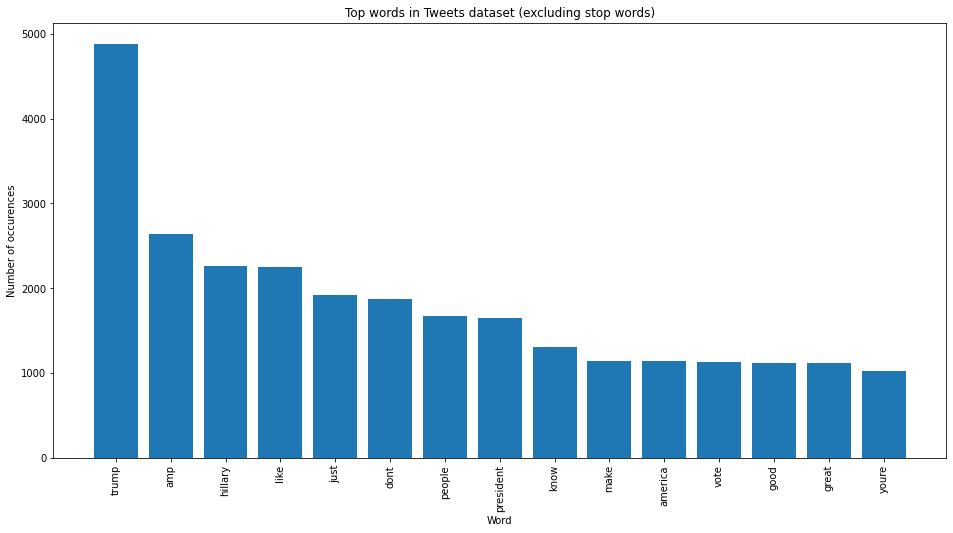

In [10]:
count_vectorizer = CountVectorizer(stop_words='english')

words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in Tweets dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [11]:
small_count_vectorizer = CountVectorizer(stop_words='english')
small_text_sample = reindexed_data.sample(n=40000, random_state=0).values

print('Headline before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample.astype('U'))

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[123]))

Headline before vectorization:  OMG Get the popcorn 
Headline after vectorization: 
  (0, 18277)	1
  (0, 19758)	1


In [12]:
n_topics = 8
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)


In [13]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [14]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [15]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [16]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  trump dont people join think know time maga makehillarybrokeagain amp
Topic 2:  like im plan trump hes people lies amp immigration trumps
Topic 3:  hillaryclinton trump hillary support tax emails thats rush amp lie
Topic 4:  press conference realdonaldtrump trump amp real like usa rt people
Topic 5:  trump amp like true poll law watch just hillary taxes
Topic 6:  trump amp president great job vote america fake leaders senate
Topic 7:  just trump like does amp look thats got account racist
Topic 8:  trump hillary good clinton just donald make like stop say


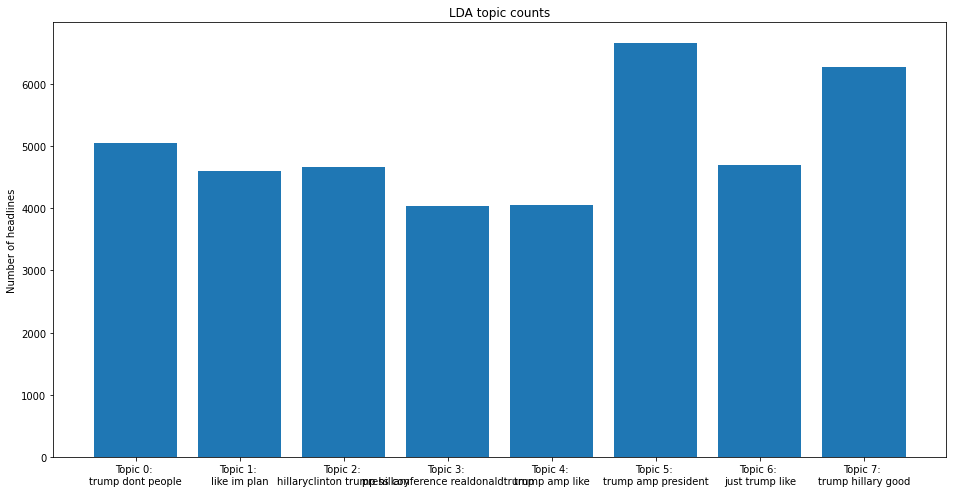

In [17]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of headlines');

In [18]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 40000 samples in 0.112s...
[t-SNE] Computed neighbors for 40000 samples in 10.836s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40000
[t-SNE] Computed conditional probabilities for sample 2000 / 40000
[t-SNE] Computed conditional probabilities for sample 3000 / 40000
[t-SNE] Computed conditional probabilities for sample 4000 / 40000
[t-SNE] Computed conditional probabilities for sample 5000 / 40000
[t-SNE] Computed conditional probabilities for sample 6000 / 40000
[t-SNE] Computed conditional probabilities for sample 7000 / 40000
[t-SNE] Computed conditional probabilities for sample 8000 / 40000
[t-SNE] Computed conditional probabilities for sample 9000 / 40000
[t-SNE] Computed conditional probabilities for sample 10000 / 40000
[t-SNE] Computed conditional probabilities for sample 11000 / 40000
[t-SNE] Computed conditional probabilities for sample 12000 / 40000
[t-SNE] Computed conditional probabilities for s

In [19]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors


In [20]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [21]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)